In [2]:
from kmeansmm import KMeansMM
import torch

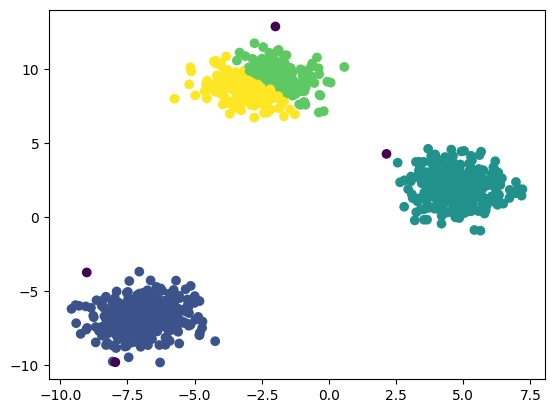

In [7]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

n_samples = 1000
X, y = make_blobs(n_samples=n_samples, random_state=42)

y_pred = KMeansMM(n_clusters=4, l=4, max_iter=1400).fit_predict(torch.FloatTensor(X))

plt.scatter(X[:, 0], X[:, 1], c=y_pred.cpu())